In [13]:
import pickle
import matplotlib.pyplot as plt
import cv2
import numpy as np
from undistort import undistort
from threshold_select import bgr_to_grayscale, bgr_to_hls, hls_channel_select, mag_sobel_hls, dir_sobel_hls, sobel_hls
from perspective_transform import perspective_transform

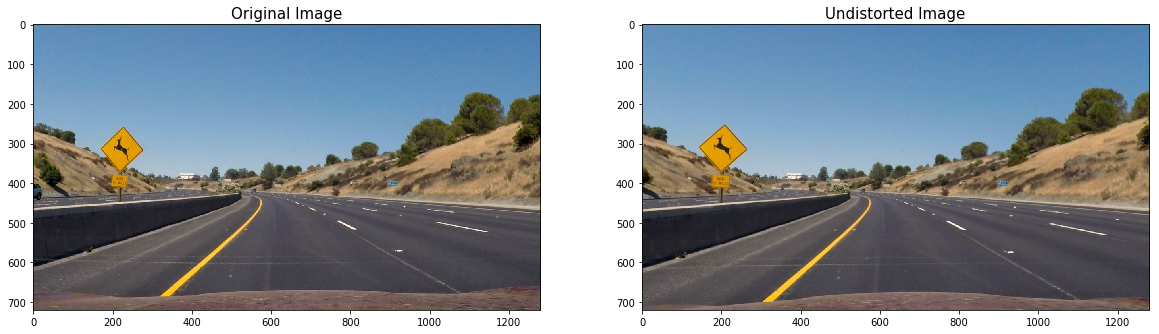

In [2]:
%matplotlib inline

image = cv2.imread('test_images/test2.jpg')

camera_calibration_file = './camera_calibration.p'
with open(camera_calibration_file, mode='rb') as f:
    cali_data = pickle.load(f)
mtx, dist = cali_data['mtx'], cali_data['dist']

undistorted_image = undistort(image, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=15)

In [10]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

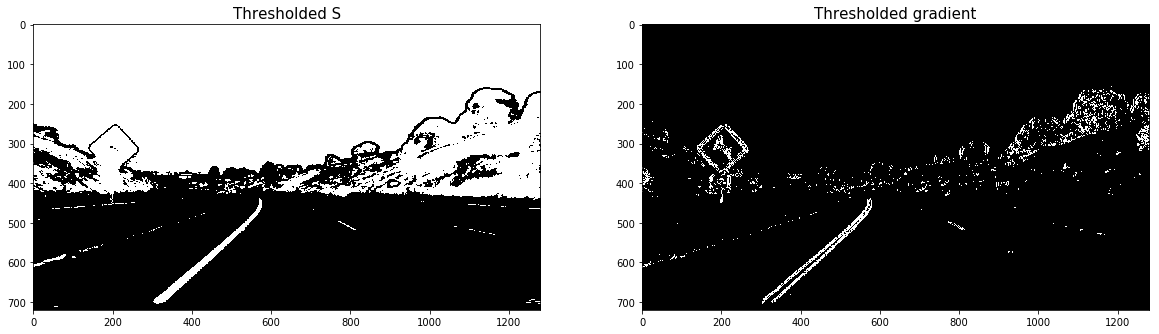

In [8]:
%matplotlib inline

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
hls = bgr_to_hls(undistorted_image)
hls_binary = hls_channel_select(hls, thresh=(60, 255))

ax1.imshow(hls_binary, cmap='gray')
ax1.set_title('Thresholded S', fontsize=15)

sobel_binary = mag_sobel_hls(hls, thresh=(20,100))

ax2.imshow(sobel_binary, cmap='gray')
ax2.set_title('Thresholded gradient', fontsize=15)

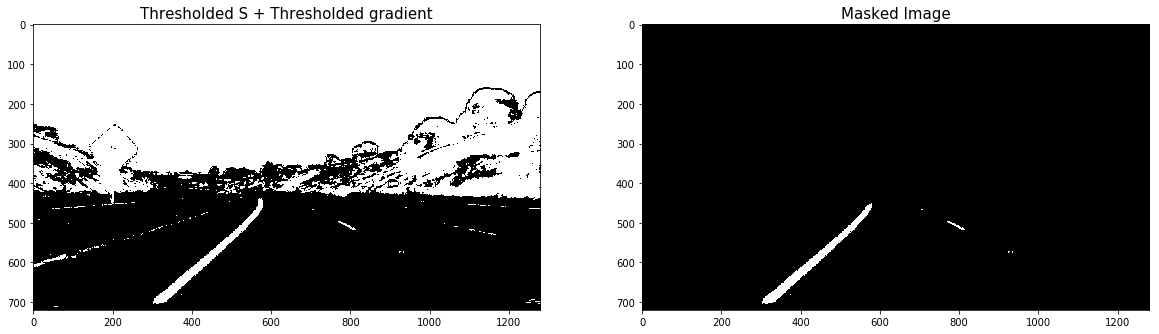

In [11]:
%matplotlib inline

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

binary_select = cv2.bitwise_or(hls_binary, sobel_binary)
ax1.imshow(binary_select, cmap='gray')
ax1.set_title('Thresholded S + Thresholded gradient', fontsize=15)

# Define a four sided polygon to mask
# Parameters for mask
height_percentage = 0.4
top_width_percentage = 0.04
bottom_width_percentage = 0.90

imshape = image.shape
top_y = int(imshape[0] * (1 - height_percentage))
top_left_x = int(imshape[1] * (1 - top_width_percentage)/2)
top_right_x = int(imshape[1] - imshape[1] * (1 - top_width_percentage)/2)
bottom_y = int(imshape[0])
bottom_left_x = int(imshape[1] * (1 - bottom_width_percentage)/2)
bottom_right_x = int(imshape[1] - imshape[1] * (1 - bottom_width_percentage)/2)    
vertices = np.array([[(bottom_left_x, bottom_y),
                      (top_left_x, top_y), 
                      (top_right_x, top_y), 
                      (bottom_right_x, bottom_y)]], 
                    dtype=np.int32)
masked_edges = region_of_interest(binary_select, vertices)
ax2.imshow(masked_edges, cmap='gray')
ax2.set_title('Masked Image', fontsize=15)

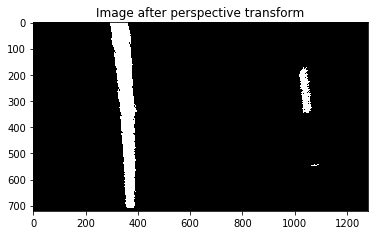

In [15]:
warped_image = perspective_transform(masked_edges)
plt.imshow(warped_image, cmap='gray')
plt.title('Image after perspective transform')